In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [192]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [193]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [194]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [195]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [196]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [197]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [198]:
# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[old_df[0]]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[new_df[0]]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1684,ECS010230100126,010000391908,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1685,ECS010230100126,010000380884,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1687,ECS010230100127,010000407833,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1686,ECS010230100127,010000390366,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1688,ECS010230100127,010000401385,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1708,ECS010230300113,010000512466,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1707,ECS010230300113,010000534846,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1709,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
1710,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
1711,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 147.1+ KB


<h4>Interpolate missing values in between dates</h4>

In [199]:
# Interpolate using spline interpolation

# Remove duplicated dates and cost rows
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Remove features that are not important
sel_feat = ['POD','RATE']
sel_df = sel_df[sel_feat]

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=sel_df['POD'].min(), end=sel_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, sel_df, on='POD', how='left')

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='spline', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(2)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-10-03,390.00
1,2005-10-04,390.07
2,2005-10-05,390.06
3,2005-10-06,390.06
4,2005-10-07,390.00


,POD,RATE
6371,2023-02-24,300.0
6372,2023-02-25,300.0
6373,2023-02-26,300.0
6374,2023-02-27,300.0
6375,2023-02-28,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6376 entries, 0 to 6375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6376 non-null   datetime64[ns]
 1   RATE    6376 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.4 KB


<h4>Grouping it to week</h4>

In [200]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\1175119283.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\1175119283.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\1175119283.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\1175119283.py:42: FutureWarning: The frame.append method is deprecated and will be r

,YearMonthWeek,Rate
0,2005-10-03,390.041429
1,2005-10-10,390.032857
2,2005-10-17,390.020000
3,2005-10-24,390.000000
4,2005-10-31,389.980000
5,2005-11-07,389.960000
6,2005-11-14,389.935714
7,2005-11-21,389.910000
8,2005-11-28,389.900000
9,2005-12-05,389.880000


,YearMonthWeek,Rate
893,2022-11-14,150.008571
894,2022-11-21,150.010000
895,2022-11-28,199.990000
896,2022-12-05,150.030000
897,2022-12-12,211.520000
898,2022-12-19,157.690000
899,2022-12-26,150.000000
900,2023-01-02,269.387143
901,2023-01-09,300.000000
902,2023-01-16,295.238571


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  908 non-null    datetime64[ns]
 1   Rate           908 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [201]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
20,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
21,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
22,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


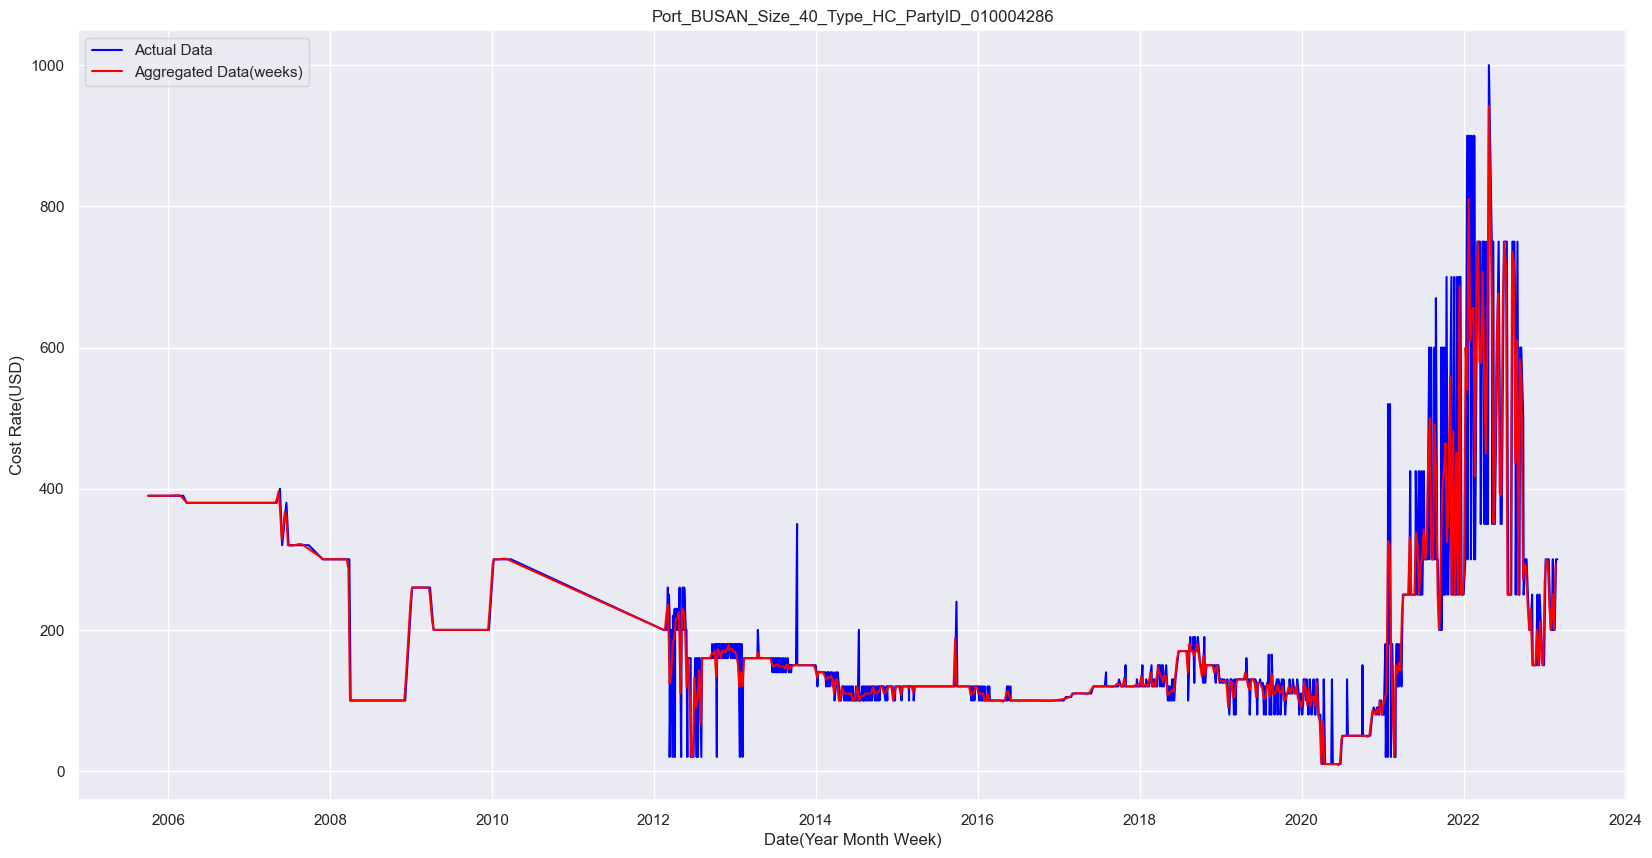

In [202]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h4>Mean Square Error Evaluation Function</h4>

In [203]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>LSTM Regression<h4>

In [225]:
from keras.layers import Dropout

# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dropout(0.3))  # 20% dropout
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh', return_sequences=True))
    model.add(LSTM(16, activation='tanh', return_sequences=True))
    model.add(LSTM(16, activation='tanh', return_sequences=True))
    model.add(LSTM(8, activation='tanh', return_sequences=True))
    model.add(LSTM(8, activation='tanh')) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=64, verbose=2, validation_data=(testX, testY))
    return model, history

def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 50 epochs...
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_337 (LSTM)             (None, 1, 64)             17920     
                                                                 
 dropout_45 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_338 (LSTM)             (None, 1, 64)             33024     
                                                                 
 lstm_339 (LSTM)             (None, 1, 32)             12416     
                                                                 
 lstm_340 (LSTM)             (None, 1, 32)             8320      
                                                                 
 lstm_341 (LSTM)             (None, 1, 16)             3136      
                                                                 
 lstm_342 (LSTM)           

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

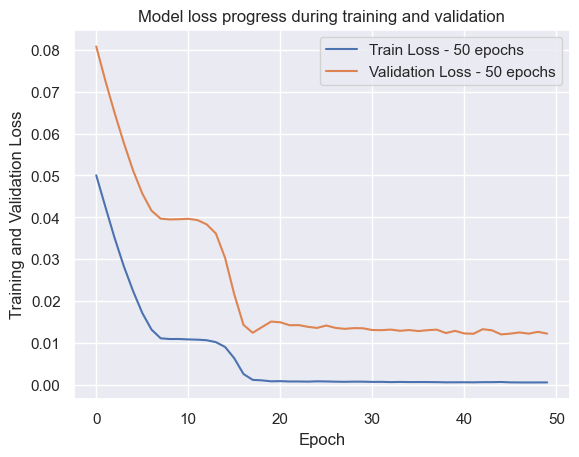

9/9 [==============================] - 0s 3ms/step
Train Score: 20.30 RMSE for 50 epochs
Test Score: 103.22 RMSE for 50 epochs
Training for 100 epochs...
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_345 (LSTM)             (None, 1, 64)             17920     
                                                                 
 dropout_46 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_346 (LSTM)             (None, 1, 64)             33024     
                                                                 
 lstm_347 (LSTM)             (None, 1, 32)             12416     
                                                                 
 lstm_348 (LSTM)             (None, 1, 32)             8320      
                                                                 
 lstm_349 (LSTM)             (N

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

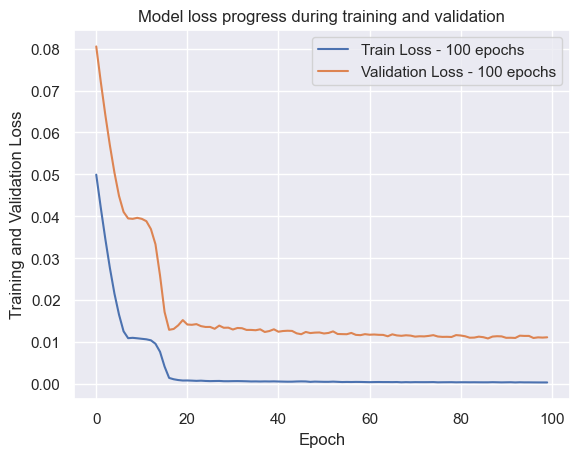

9/9 [==============================] - 0s 3ms/step
Train Score: 17.02 RMSE for 100 epochs
Test Score: 98.60 RMSE for 100 epochs
Training for 300 epochs...
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_353 (LSTM)             (None, 1, 64)             17920     
                                                                 
 dropout_47 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_354 (LSTM)             (None, 1, 64)             33024     
                                                                 
 lstm_355 (LSTM)             (None, 1, 32)             12416     
                                                                 
 lstm_356 (LSTM)             (None, 1, 32)             8320      
                                                                 
 lstm_357 (LSTM)             (

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

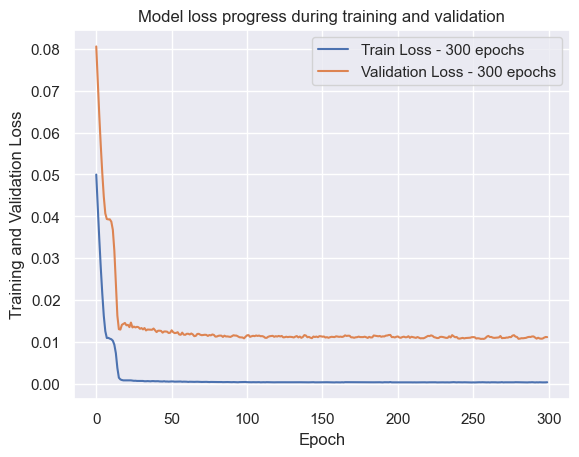

9/9 [==============================] - 0s 3ms/step
Train Score: 16.33 RMSE for 300 epochs
Test Score: 98.64 RMSE for 300 epochs
     Train RMSE   Test RMSE
50    20.300335  103.220816
100   17.021497   98.598825
300   16.332106   98.639262


In [226]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(agg_df['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [50, 100, 300]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

# # View how LSTM model fitting to the actual data
# plot_predictions_v1(dataset, trainPredict, testPredict, look_back)


<h4>Forecast the results</h4>

In [227]:
def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    input_values = np.array(last_values)
    for _ in range(n_weeks):
        # Scale the input_values to be between 0 and 1
        input_values_scaled = scaler.transform(input_values[-look_back:].reshape(-1, 1))
        
        # Reshape to [samples, time steps, features]
        input_values_scaled = input_values_scaled.reshape((1, 1, look_back))

        # Predict the next value
        prediction = model.predict(input_values_scaled)
        
        # Inverse scale the predicted value
        prediction = scaler.inverse_transform(prediction)
        
        # Append the predicted value to the forecast list
        forecast.append(prediction[0, 0])
        
        # Append the predicted value to the input_values list to be used as input for the next prediction
        input_values = np.append(input_values, prediction)

    return forecast


In [228]:
# How many weeks you want to forecast
weeks = 12  # approximately equal to 240 days

# Get the last "look_back" values
last_values = list(df_interpolated['RATE'].values[-look_back:])

# Forecast the next weeks
forecasted_values = forecast_next_weeks(model, look_back, scaler, last_values, weeks)

# Get the last date from 'POD'
last_date = df_interpolated['POD'].iloc[-1]

# Create new dates
new_dates = pd.date_range(last_date + pd.DateOffset(weeks=1), periods=weeks, freq='W')

# Create a new DataFrame for the forecasted values
df_forecasted = pd.DataFrame(data={'POD': new_dates, 'RATE': forecasted_values})

# Rounding of the rate nearest 2 decimal point
df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


,POD,RATE
0,2023-03-12,297.329987
1,2023-03-19,295.329987
2,2023-03-26,293.329987
3,2023-04-02,291.100006
4,2023-04-09,288.640015


,POD,RATE
7,2023-04-30,281.220001
8,2023-05-07,278.559998
9,2023-05-14,275.820007
10,2023-05-21,272.950012
11,2023-05-28,269.959991


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [229]:
# Create an empty DataFrame to store comparison data
comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual', 'error', 'accuracy'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

# Loop over df_forecasted
for _, row in df_forecasted.iterrows():
    # Find the actual dates within the week of the forecasted date
    # Add a 'WeekEnd' column to df_forecasted
    mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    # Calculate the error and accuracy for each actual date within the week
    for _, actual_row in actual_dates_within_week.iterrows():
        error = abs(actual_row['RATE'] - row['RATE'])
        error_proportion = error / actual_row['RATE']
        accuracy = (1 - error_proportion) * 100

        # Append the data to comparison_df
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE'],
            'error': error,
            'accuracy': accuracy
        }, ignore_index=True)

# Remove duplicates based on 'POD_actual', 'RATE_forecasted', and 'RATE_actual'
comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Display the comparison dataframe
comparison_df
comparison_df.info()

total_mean_accuracy = comparison_df['accuracy'].mean()
print(f'The mean accuracy is {total_mean_accuracy:.2f}%')


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\2601120271.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\2601120271.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\2601120271.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_23456\2601120271.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({


,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,error,accuracy
0,2023-03-12,2023-03-19,2023-03-15,297.329987,260.0,37.329987,85.642313
1,2023-03-19,2023-03-26,2023-03-19,295.329987,300.0,4.670013,98.443329
2,2023-03-26,2023-04-02,2023-03-26,293.329987,260.0,33.329987,87.180774
3,2023-03-26,2023-04-02,2023-04-01,293.329987,260.0,33.329987,87.180774
4,2023-04-02,2023-04-09,2023-04-08,291.100006,260.0,31.100006,88.038459
5,2023-04-09,2023-04-16,2023-04-12,288.640015,300.0,11.359985,96.213338
6,2023-04-09,2023-04-16,2023-04-15,288.640015,260.0,28.640015,88.984610
7,2023-04-16,2023-04-23,2023-04-20,286.260010,260.0,26.260010,89.899996
8,2023-04-23,2023-04-30,2023-04-26,283.799988,300.0,16.200012,94.599996
9,2023-04-30,2023-05-07,2023-05-03,281.220001,260.0,21.220001,91.838461


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   WeekStart        12 non-null     datetime64[ns]
 1   WeekEnd          12 non-null     datetime64[ns]
 2   POD_actual       12 non-null     datetime64[ns]
 3   RATE_forecasted  12 non-null     float64       
 4   RATE_actual      12 non-null     float64       
 5   error            12 non-null     float64       
 6   accuracy         12 non-null     float64       
dtypes: datetime64[ns](3), float64(4)
memory usage: 800.0 bytes
The mean accuracy is 91.23%


<h4>Visualise all, Conclusion</h4>

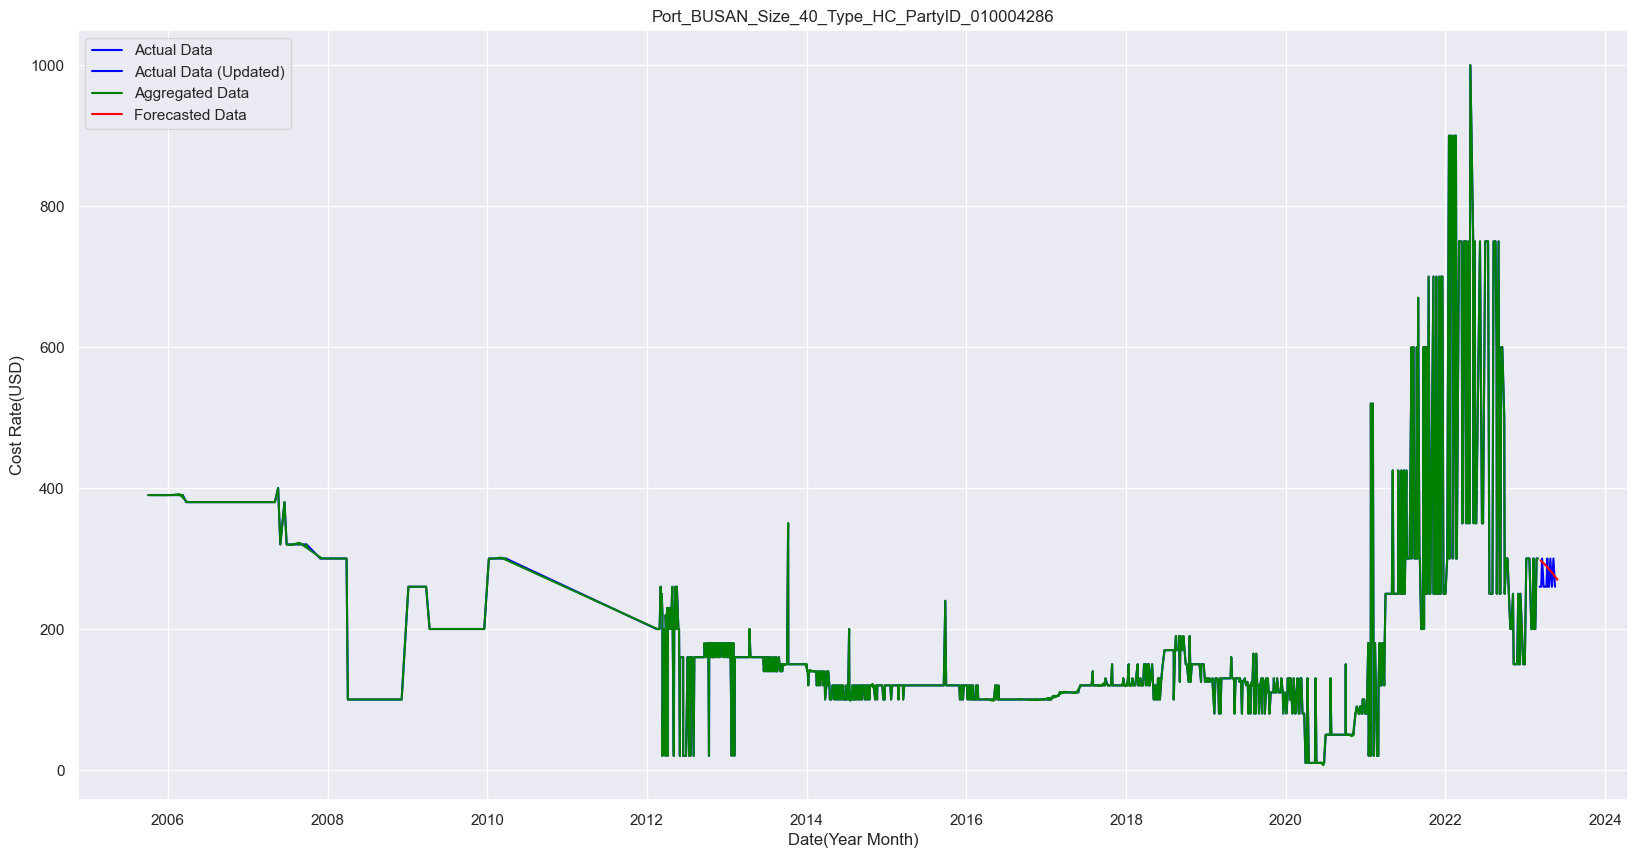

In [230]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();